In [2]:
import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import scipy.interpolate as interpolate
import datetime
import pandas as pd
import scipy.signal as signal
import scipy.fft as fft
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from IPython.display import HTML

In [3]:
diri="/home/anindya/trmm"
valid_paths = next(os.walk(diri), (None, None, []))[2]


In [4]:
ds=nc.Dataset(diri+"/"+'3B42_Daily.20031014.7.nc4')
latitude=np.array(ds['lat'][:])
longitude=np.array(ds['lon'][:])

index_lat= lambda lat: int((lat+2.95)/0.1)
index_lon= lambda lon: int((lon-62.75)/0.1)
lat= lambda index_lat: -2.95+index_lat*0.1
lon= lambda index_lon: 62.75+index_lon*0.1
Bangalore_lat_index=[index_lat(12.05),index_lat(14.05)]
Bangalore_lon_index=[index_lon(76.55),index_lon(78.55)]


In [40]:

start = datetime.datetime.strptime("19980101", "%Y%m%d")
end = datetime.datetime.strptime("20191230", "%Y%m%d")
date_generated = pd.date_range(start, end)
dates=date_generated.strftime("%Y%m%d")


daily_data=[]
data_shape=[]
for date in dates:
    search_path='3B42_Daily.'+date+'.7.nc4'
    if search_path in valid_paths:
        ds=nc.Dataset(diri+"/"+search_path)
        rain=np.array(ds['precipitation'][:]) 
               
        daily_data.append(rain[Bangalore_lon_index[0]:Bangalore_lon_index[1]+1,Bangalore_lat_index[0]:Bangalore_lat_index[1]+1])
        data_shape=daily_data[-1].shape
    else:
        daily_data.append("dummy")  
missed=[i for i,x in enumerate(daily_data) if x=="dummy"]
x=[i for i in range(len(daily_data)) if i not in missed]
y=list(daily_data)

try:
    while True:
        y.remove("dummy")
except ValueError:
    pass
y=np.array(y)
daily_recon=np.zeros(shape=(len(daily_data),)+data_shape)
x_1=np.array([i for i in range(len(daily_data))])
for i in range(data_shape[0]):
    for j in range(data_shape[1]):
        f=interpolate.interp1d(x,y[:,i,j])        
        daily_recon[:,i,j]=f(x_1)


    
#plt.plot(np.sum(daily_recon,axis=(1,2)))
rain_data=np.sum(daily_recon,axis=(1,2))


/tmp/ipykernel_898405/175011895.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missed=[i for i,x in enumerate(daily_data) if x=="dummy"]
/tmp/ipykernel_898405/175011895.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y.remove("dummy")


In [35]:
India_lat_index=[index_lat(8.05),index_lat(37.05)]
India_lon_index=[index_lon(68.55),index_lon(97.55)]
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature


polygon = Polygon(
    [
        [
            (27.54,89.05),
            (34.73,76.61),
            (23.82,68.03),
            (20.77,70.40),
            (21.95,72.78),
            (16.86,73.33),
            (8.13,77.43),
            (13.21,80.45),
            (16.70,82.26),
            (21.97,88.10),
            (22.7,91.52),
            (27.54,89.05)
        ]
    ]
)
points=[]
x=8.05
y=68.55
while x<=37.05:
    while y<=97.55:
        
        if boolean_point_in_polygon(Feature(geometry=Point((x,y))), polygon):
            points.append((x,y))
        y+=0.25
    x+=0.25
    x+=0.25
    y=68.55
start = datetime.datetime.strptime("19980101", "%Y%m%d")
end = datetime.datetime.strptime("20191230", "%Y%m%d")
date_generated = pd.date_range(start, end)
dates=date_generated.strftime("%Y%m%d")


daily_data=[]
data_shape=[]
for date in dates:
    search_path='3B42_Daily.'+date+'.7.nc4'
    if search_path in valid_paths:
        ds=nc.Dataset(diri+"/"+search_path)
        rain=np.array(ds['precipitation'][:]) 
        meas=0
        for pt in points: meas+=rain[index_lat(pt[0]),index_lon(pt[1])]
        daily_data.append(meas)
        
    else:
        daily_data.append("dummy")  
missed=[i for i,x in enumerate(daily_data) if x=="dummy"]
x=[i for i in range(len(daily_data)) if i not in missed]
y=list(daily_data)

try:
    while True:
        y.remove("dummy")
except ValueError:
    pass
y=np.array(y)
daily_recon=np.zeros(shape=(len(daily_data),))
x_1=np.array([i for i in range(len(daily_data))])
f=interpolate.interp1d(x,y)        
daily_recon=f(x_1)


    
#plt.plot(np.sum(daily_recon,axis=(1,2)))
rain_data_India=daily_recon


In [38]:
import scipy.stats
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

period=365
spacing=1
cycles=rain_data.shape[0]//period

periodic_sliced_IND=[]
periodic_sliced_ma=[]
Y=[]
sos = signal.butter(20, 0.33, 'lowpass', fs=1, output='sos')

for i in range(1,cycles):
    #periodic_sliced.append(signal.sosfilt(sos,rain_data[i*period:(i+1)*period] ))
    periodic_sliced_IND.append(rain_data_India[i*period:(i+1)*period])
    

rain_av_IND=sum(periodic_sliced_IND)/(cycles-1)
std_S_IND=np.zeros(shape=rain_av_IND.shape)
for c in range(1,cycles-1):
    dev=np.power(periodic_sliced_IND[c]-rain_av_IND,2)
    std_S_IND+=dev
std_S_IND/=(cycles-1)
std_S_IND=np.power(std_S_IND,0.5)

Upper_limit_IND=rain_av_IND+std_S_IND*scipy.stats.t.ppf(q=1-.10/2,df=cycles-1)/cycles**0.5
Lower_limit_IND=rain_av_IND-std_S_IND*scipy.stats.t.ppf(q=1-.10/2,df=cycles-1)/cycles**0.5


rain_av_IND/=(India_lat_index[-1]-India_lat_index[0])*(India_lon_index[-1]-India_lon_index[0])
Lower_limit_IND/=(India_lat_index[-1]-India_lat_index[0])*(India_lon_index[-1]-India_lon_index[0])
Upper_limit_IND/=(India_lat_index[-1]-India_lat_index[0])*(India_lon_index[-1]-India_lon_index[0])


In [41]:

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

period=365
spacing=1
cycles=rain_data.shape[0]//period

periodic_sliced=[]
periodic_sliced_ma=[]
Y=[]
sos = signal.butter(20, 0.33, 'lowpass', fs=1, output='sos')

for i in range(cycles):
    #periodic_sliced.append(signal.sosfilt(sos,rain_data[i*period:(i+1)*period] ))
    periodic_sliced.append(rain_data[i*period:(i+1)*period])
    periodic_sliced_ma.append(moving_average(rain_data[i*period:(i+1)*period],20))
    Y.append((2/period)*np.abs(fft.fft(periodic_sliced[-1])[:period//2]))
Y_av=sum(Y)/cycles

rain_av=sum(periodic_sliced)/cycles
std_S=np.zeros(shape=rain_av.shape)
for c in range(cycles):
    dev=np.power(periodic_sliced[c]-rain_av,2)
    std_S+=dev
std_S/=(cycles-1)
std_S=np.power(std_S,0.5)

Upper_limit=rain_av+std_S*scipy.stats.t.ppf(q=1-.10/2,df=cycles)/cycles**0.5
Lower_limit=rain_av-std_S*scipy.stats.t.ppf(q=1-.10/2,df=cycles)/cycles**0.5

rain_av/=64
Lower_limit/=64
Upper_limit/=64


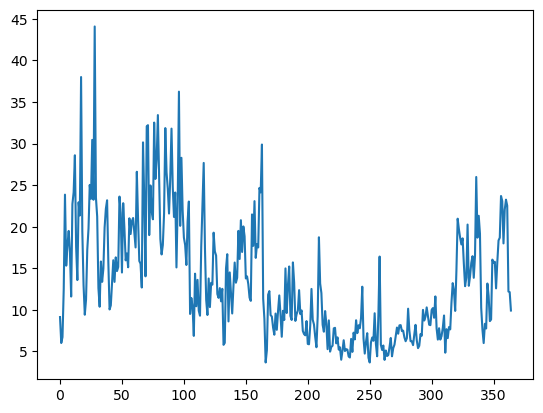

In [42]:
plt.plot(rain_av)

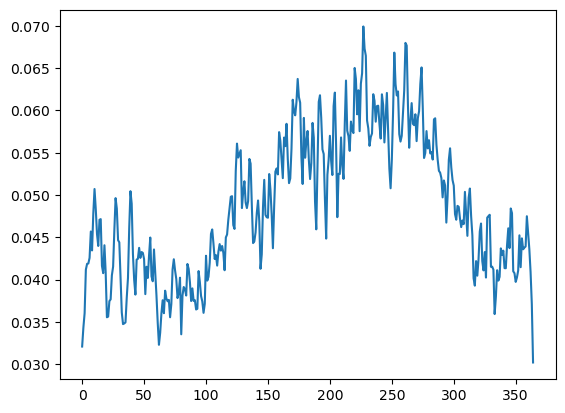

In [43]:
plt.plot(rain_av_IND[::-1])